# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 94.8 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2024

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
# Variable encoding
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode.

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
    dcor_df : pandas.DataFrame
        The distance correlation matrix as a pandas DataFrame.

    Returns:
    Histogram plot of the correlations.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates 10 bins with edges at 0, 0.1, 0.2, ..., 1.0
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

Pre-feature selection

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

# **Load data**

In [ ]:
variable_rename = {
    'Attribute1': 'Status_of_existing_checking_account',
    'Attribute2': 'Duration',
    'Attribute3': 'Credit_history',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_amount',
    'Attribute6': 'Savings_account_bonds',
    'Attribute7': 'Present_employment_since',
    'Attribute8': 'Installment_rate_in_percentage_of_disposable_income',
    'Attribute9': 'Personal_status_and_sex',
    'Attribute10': 'Other_debtors_guarantors',
    'Attribute11': 'Present_residence_since',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'Other_installment_plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Number_of_existing_credits_at_this_bank',
    'Attribute17': 'Job',
    'Attribute18': 'Number_of_people_being_liable_to_provide_maintenance_for',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_worker',
    'class': 'Target'
}

german_credit, german_variables = load_data_from_ucimlrepo(144, variable_rename_dict=variable_rename)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
german_credit.head()

,Status_of_existing_checking_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,Foreign_worker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
german_variables

,name,role,type,demographic,description,units,missing_values
0,Status_of_existing_checking_account,Feature,Categorical,None,Status of existing checking account,None,no
1,Duration,Feature,Integer,None,Duration,months,no
2,Credit_history,Feature,Categorical,None,Credit history,None,no
3,Purpose,Feature,Categorical,None,Purpose,None,no
4,Credit_amount,Feature,Integer,None,Credit amount,None,no
5,Savings_account_bonds,Feature,Categorical,None,Savings account/bonds,None,no
6,Present_employment_since,Feature,Categorical,Other,Present employment since,None,no
7,Installment_rate_in_percentage_of_disposable_i...,Feature,Integer,None,Installment rate in percentage of disposable i...,None,no
8,Personal_status_and_sex,Feature,Categorical,Marital Status,Personal status and sex,None,no
9,Other_debtors_guarantors,Feature,Categorical,None,Other debtors / guarantors,None,no


## Make feature names and feature values more human-interpretable

In [ ]:
# Dictionaries for each categorical attribute
Status_of_existing_checking_account = {
    'A11': 'less than 0 DM',
    'A12': 'from 0 to 200 DM',
    'A13': 'greater or equal to 200 DM or salary assignments',
    'A14': 'no checking account'
}

Credit_history = {
    'A30': 'no credits taken or all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account or other credits existing'
}

Purpose = {
    'A40': 'car new',
    'A41': 'car used',
    'A42': 'furniture or equipment',
    'A43': 'radio or television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

Savings_account_bonds = {
    'A61': 'less than 100 DM',
    'A62': 'from 100 to 500 DM',
    'A63': 'from 500 to 1000 DM',
    'A64': 'greater or equal to 1000 DM',
    'A65': 'unknown/no savings account'
}

Present_employment_since = {
    'A71': 'unemployed',
    'A72': 'less than 1 year',
    'A73': 'from 1 to 4 years',
    'A74': 'from 4 to 7 years',
    'A75': 'greater or equal to 7 years'
}

Personal_status_and_sex = {
    'A91': 'male divorced or separated',
    'A92': 'female divorced or separated or married',
    'A93': 'male single',
    'A94': 'male married or widowed',
    'A95': 'female single'
}

Other_debtors_guarantors = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

Property = {
    'A121': 'real estate',
    'A122': 'building society savings or agreement or life insurance',
    'A123': 'car or other',
    'A124': 'unknown or no property'
}

Other_installment_plans = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

Housing = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

Job = {
    'A171': 'unemployed or unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee or official',
    'A174': 'management or self-employed or highly qualified employee or officer'
}

Telephone = {
    'A191': 'no',
    'A192': 'yes'
}

Foreign_worker = {
    'A201': 'yes',
    'A202': 'no'
}

Target = {
    1: 'good',
    2: 'bad'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'Status_of_existing_checking_account': Status_of_existing_checking_account,
    'Credit_history': Credit_history,
    'Purpose': Purpose,
    'Savings_account_bonds': Savings_account_bonds,
    'Present_employment_since': Present_employment_since,
    'Personal_status_and_sex': Personal_status_and_sex,
    'Other_debtors_guarantors': Other_debtors_guarantors,
    'Property': Property,
    'Other_installment_plans': Other_installment_plans,
    'Housing': Housing,
    'Job': Job,
    'Telephone': Telephone,
    'Foreign_worker': Foreign_worker,
    'Target': Target
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    german_credit[column] = german_credit[column].map(mapping)

german_credit.head()

,Status_of_existing_checking_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,Foreign_worker,Target
0,less than 0 DM,6,critical account or other credits existing,radio or television,1169,unknown/no savings account,greater or equal to 7 years,4,male single,none,...,real estate,67,none,own,2,skilled employee or official,1,yes,yes,good
1,from 0 to 200 DM,48,existing credits paid back duly till now,radio or television,5951,less than 100 DM,from 1 to 4 years,2,female divorced or separated or married,none,...,real estate,22,none,own,1,skilled employee or official,1,no,yes,bad
2,no checking account,12,critical account or other credits existing,education,2096,less than 100 DM,from 4 to 7 years,2,male single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,good
3,less than 0 DM,42,existing credits paid back duly till now,furniture or equipment,7882,less than 100 DM,from 4 to 7 years,2,male single,guarantor,...,building society savings or agreement or life ...,45,none,for free,1,skilled employee or official,2,no,yes,good
4,less than 0 DM,24,delay in paying off in the past,car new,4870,less than 100 DM,from 1 to 4 years,3,male single,none,...,unknown or no property,53,none,for free,2,skilled employee or official,2,no,yes,bad


# **Split data in train and test set**

In [ ]:
german_credit_train, german_credit_test = train_test_split(
    german_credit, test_size=0.2, random_state=RANDOM_STATE, stratify=german_credit["Target"]
)
german_credit_train['Target'].value_counts()

,count
Target,
good,560
bad,240


## Variable encoding

In [ ]:
cat_variables = (
    list(german_variables[german_variables['type']=='Binary']['name']) +
    list(german_variables[german_variables['type']=='Categorical']['name'])
)

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
german_credit_train_encoded, german_ohe = one_hot_encoding(german_credit_train, cat_variables, encoder=None)
german_credit_test_encoded, _ = one_hot_encoding(german_credit_test, cat_variables, encoder=german_ohe)

# Traget variable encoding for the project 0: "Good" and 1: "Bad", useful for F1 calculation
Target_encoder = {
    'good': 0.0,
    'bad': 1.0
}
german_credit_train_encoded = encode_binary_variables(german_credit_train_encoded, ['Target'], Target_encoder)
german_credit_test_encoded = encode_binary_variables(german_credit_test_encoded, ['Target'], Target_encoder)

# move target variable to the end of the dataframe
X_vars = [col for col in german_credit_train_encoded.columns if col != 'Target']
german_credit_train_encoded = german_credit_train_encoded[X_vars + ['Target']]
german_credit_test_encoded = german_credit_test_encoded[X_vars + ['Target']]

german_encoded_vars_family = map_encoded_variables_to_original(german_credit_train_encoded.columns, cat_variables)

Categorical variables:  ['Telephone', 'Foreign_worker', 'Status_of_existing_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds', 'Present_employment_since', 'Personal_status_and_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job']


In [ ]:
german_credit_train_encoded.head()

,Duration,Credit_amount,Installment_rate_in_percentage_of_disposable_income,Present_residence_since,Age,Number_of_existing_credits_at_this_bank,Number_of_people_being_liable_to_provide_maintenance_for,Telephone_yes,Foreign_worker_yes,Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments,...,Property_real estate,Property_unknown or no property,Other_installment_plans_none,Other_installment_plans_stores,Housing_own,Housing_rent,Job_skilled employee or official,Job_unemployed or unskilled - non-resident,Job_unskilled - resident,Target
254,9,2030,2,1,24,1,1,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
413,10,1597,3,2,40,1,2,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
465,24,2924,3,4,63,1,2,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
188,12,674,4,1,20,1,1,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
724,27,2570,3,3,21,1,1,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [ ]:
german_credit_train_encoded.columns

Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purpose_repairs',

In [ ]:
german_encoded_vars_family

{'Telephone_yes': 'Telephone',
 'Foreign_worker_yes': 'Foreign_worker',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_less than 0 DM': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_no checking account': 'Status_of_existing_checking_account',
 'Credit_history_critical account or other credits existing': 'Credit_history',
 'Credit_history_delay in paying off in the past': 'Credit_history',
 'Credit_history_existing credits paid back duly till now': 'Credit_history',
 'Credit_history_no credits taken or all credits paid back duly': 'Credit_history',
 'Purpose_car new': 'Purpose',
 'Purpose_car used': 'Purpose',
 'Purpose_domestic appliances': 'Purpose',
 'Purpose_education': 'Purpose',
 'Purpose_furniture or equipment': 'Purpose',
 'Purpose_others': 'Purpose',
 'Purpose_radio or television': 'Purpose',
 'Purpose_repairs': 'Purpose',
 'Purpo

# **Data summary and quality**

In [ ]:
describe_data(german_credit_train_encoded)


Data dimension :
Number of Records :  800 
Number of Features :  49

Datatype of Features :
float64    42
int64       7
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
         Duration  Credit_amount  \
count  800.000000     800.000000   
mean    21.473750    3334.226250   
std     12.187287    2866.705591   
min      4.000000     276.000000   
25%     12.000000    1399.750000   
50%     18.000000    2332.000000   
75%     24.000000    3981.750000   
max     72.000000   18424.000000   

       Installment_rate_in_percentage_of_disposable_income  \
count                                         800.000000     
mean                                            2.990000     
std                                             1.118689     
min                                             1.000000     
25%                                             2.000000     
50%                                 

# **Correlation**

In [ ]:
german_credit_train_encoded.dtypes

,0
Duration,int64
Credit_amount,int64
Installment_rate_in_percentage_of_disposable_income,int64
Present_residence_since,int64
Age,int64
Number_of_existing_credits_at_this_bank,int64
Number_of_people_being_liable_to_provide_maintenance_for,int64
Telephone_yes,float64
Foreign_worker_yes,float64
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments,float64


Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

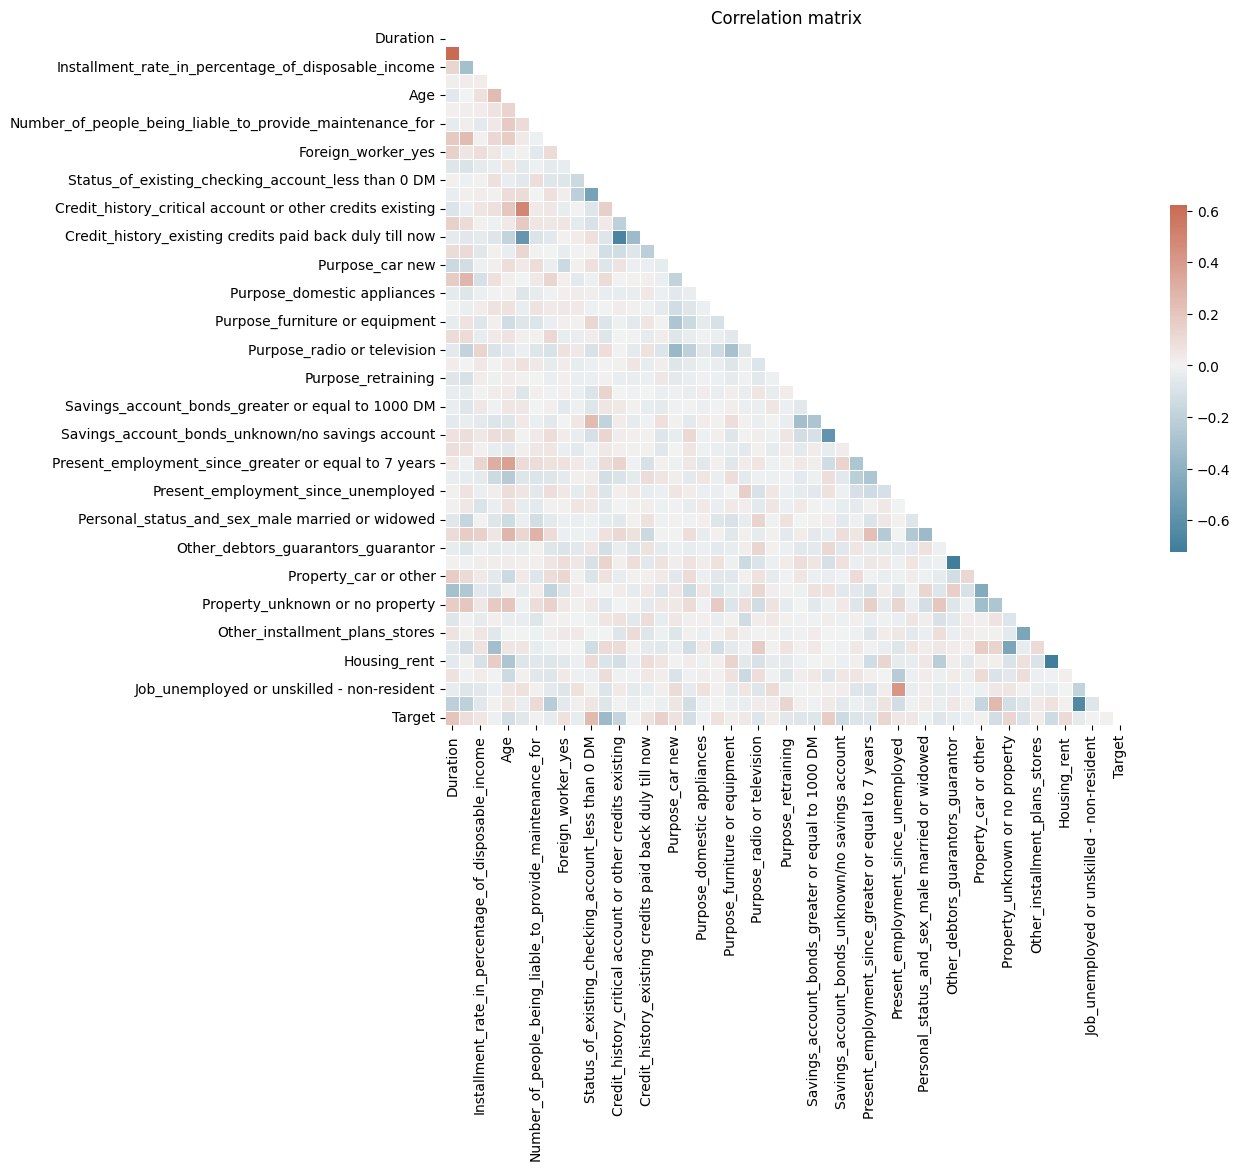

In [ ]:
german_corr = calculate_correlation(german_credit_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(german_corr['Target']).sort_values(ascending=False)

,Target
Target,1.000000
Status_of_existing_checking_account_no checking account,0.346321
Status_of_existing_checking_account_less than 0 DM,0.257063
Duration,0.210009
Credit_history_critical account or other credits existing,0.177936
Savings_account_bonds_less than 100 DM,0.164642
Savings_account_bonds_unknown/no savings account,0.148613
Credit_history_no credits taken or all credits paid back duly,0.144767
Housing_own,0.142948
Present_employment_since_less than 1 year,0.133869


df columns:  Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purp

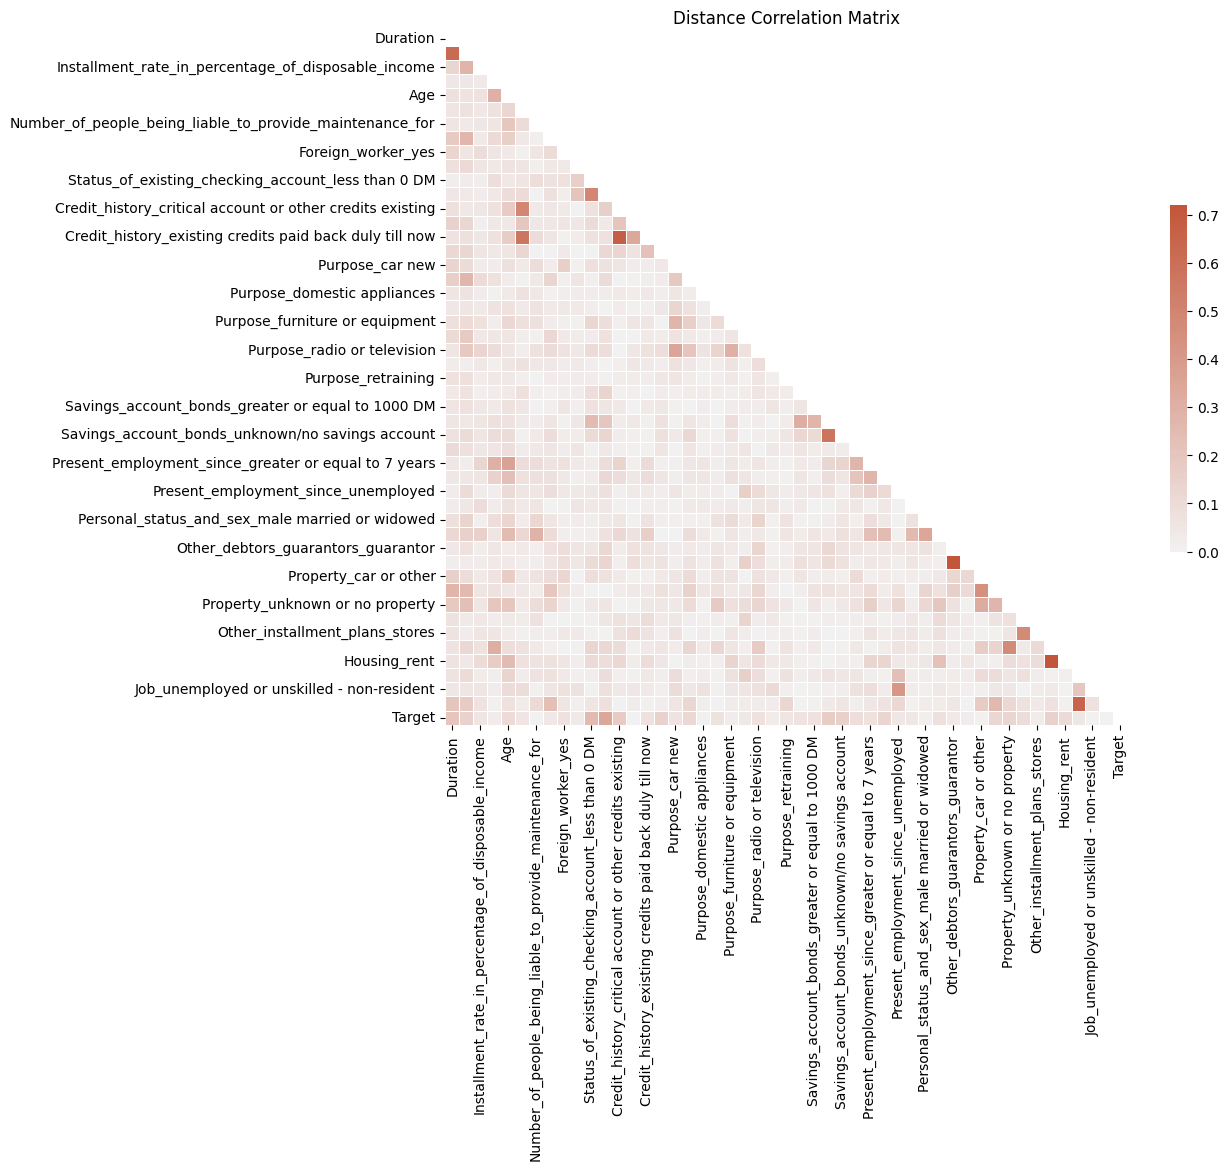

In [ ]:
german_dist_corr = calculate_distance_correlation_matrix(german_credit_train_encoded)

In [ ]:
german_dist_corr['Target'].sort_values(ascending=False)

,Target
Target,1.000000
Status_of_existing_checking_account_no checking account,0.346321
Status_of_existing_checking_account_less than 0 DM,0.257063
Duration,0.207775
Credit_history_critical account or other credits existing,0.177936
Savings_account_bonds_less than 100 DM,0.164642
Savings_account_bonds_unknown/no savings account,0.148613
Credit_history_no credits taken or all credits paid back duly,0.144767
Housing_own,0.142948
Credit_amount,0.142669


# **Pre-feature selection + Remove intercorrelated features**
Features with zero-variance or extremely weak correlation with the target variable will be dropped. Additionally, intercorrelated features will be dropped as well with only one remaining.

In [ ]:
filtered_features = filter_out_intercorrelated_features(german_dist_corr, 'Target', 0.8)

appended feature:  Status_of_existing_checking_account_no checking account
appended feature:  Status_of_existing_checking_account_less than 0 DM
appended feature:  Duration
appended feature:  Credit_history_critical account or other credits existing
appended feature:  Savings_account_bonds_less than 100 DM
appended feature:  Savings_account_bonds_unknown/no savings account
appended feature:  Credit_history_no credits taken or all credits paid back duly
appended feature:  Housing_own
appended feature:  Credit_amount
appended feature:  Present_employment_since_less than 1 year
appended feature:  Property_unknown or no property
appended feature:  Property_real estate
appended feature:  Purpose_car used
appended feature:  Housing_rent
appended feature:  Age
appended feature:  Other_installment_plans_none
appended feature:  Present_employment_since_from 4 to 7 years
appended feature:  Personal_status_and_sex_male single
appended feature:  Present_employment_since_greater or equal to 7 years

In [ ]:
intercorrelated_feat_removed = [col for col in german_dist_corr.columns if col not in filtered_features and col!='Target']
intercorrelated_feat_removed

[]

Due to no feature being removed this Scenario becomes equal to Scenario 1 (Standard)